This dataset is obtained as a result of detonating malware and 'cleanware' in a cyber range. The idea is to see if malaware can be distinguished from cleanware based on its dynamic behaviour.

Host logs were generated using the Wintap tool (Open source software developed by LLNL). Labels were assigned to each sample (malicious or benign) by checking the results from different anti-virus engines. A voting scheme was used to combine the results from the AV engines into a single label (malicious, benign or unknown). Samples with no clear consensus from the AV engines (i.e. a label of unknown) were excluded from the dataset.

Wintap generates a comprehensive set of logs. For this data set we have used a sub-set of Wintap logs into a single event table in parent-child form. Each event consists of:

* An experiment ID
* A timestamp
* A rulename (the type of event: process create, image load, netwok connection etc)
* The name of the paret process
* The name of the child (which could be a process, file name, network connection etc)
* A unique globally unique identifier (guid) for the parent process
* A unique guid for the child

A labeled data set is provided as ground truth. As well as a label (malicious or benign) the data also contains the year that the software was first observed. The data has been pre-split into a test set and a training set.

Only events that occur as a result of the detonation are recorded. The process tree underneath each detonation has been constructed elsewhere and only the enitities that belong to the process tree are recorded. Thus there are no events present from background activity.

This starter notebook:

* Loads in the data (both event data and ground truth)
* Creates a simple feature vector of counts
* Carries out some simple EDA
* Performs baseline machine learning using the counts feature vector

An accuracy of 92% is achieved. More sophisticated feature vectors can improve on this. The dates of the malware and cleanware are provided. Malware from 2024 is included in the test set but not the training set. These dates can be used to demonstrate model drift.

In [1]:
# library imports
import numpy as np
import io
from io import StringIO
import statistics
import math
import json
from collections import Counter
from collections import OrderedDict
import time
import random
import string
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, auc, roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from bokeh.plotting import show, save, output_notebook, output_file
from scipy.sparse import hstack, vstack

In [2]:
def display_graphs(df, labels, ncols, main_title, thresh):
    n_graph = len(labels)
    nrows = int(n_graph/ncols)
    if n_graph/ncols > nrows:
        nrows = nrows + 1
    plt.clf()
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols,5.5*nrows),constrained_layout=True)
    x_ind = 0
    y_ind = 0
    
    for lab in labels:
        ax1 = axes[x_ind, y_ind]
        if (lab == 'process_life') | (lab == 'elapsed time'):
            sub = df
        else:
            sub = df[df[lab]<=thresh]
        numgt100 = len(df) - len(sub)
        ax1.hist(sub[lab],bins=50)
        #ax1.hist(sub[lab],width=5.0)
        title = lab
        if numgt100>0:
            title = title + " (Number > " +str(thresh) + " = " +str(numgt100)+")"
        ax1.set_xlim(-10,thresh)
        ax1.set_title(title)
        y_ind = y_ind+1
        if y_ind == ncols:
            y_ind=0
            x_ind = x_ind + 1
    main_title1 = main_title + " (" +str(len(df)) +")"
    fig.suptitle(main_title1)
    plt.show()
    return

In [3]:
root = '~/Downloads/llnl-malware/'

train_labels = root + 'truth_labels_train.json'
test_labels = root + 'truth_labels_test.json'
tree_files = ['trees_0.json','trees_1.json','trees_2.json','trees_3.json','trees_4.json','trees_5.json',
              'trees_6.json','trees_7.json']

In [4]:
# Get Truth Data
df_truth_train = pd.read_json(train_labels)
df_truth_train['test'] = False
display(df_truth_train.head())
print(df_truth_train['label'].value_counts())

df_truth_test = pd.read_json(test_labels)
df_truth_test['test'] = True
display(df_truth_test.head())
print(df_truth_test['label'].value_counts())

df_truth = pd.concat([df_truth_train, df_truth_test]).reset_index().drop('index',axis=1)

,experiment,year,label,test
0,E53002,2023,benign,False
1,E30273,2021,malicious,False
2,E27878,2023,benign,False
3,E27833,2017,malicious,False
4,E25807,2023,benign,False


label
benign       20000
malicious    20000
Name: count, dtype: int64


,experiment,year,label,test
0,E33423,2024.0,benign,True
1,E39699,2017.0,malicious,True
2,E16707,2017.0,malicious,True
3,E44183,2017.0,malicious,True
4,E60380,2017.0,malicious,True


label
malicious    19498
benign        5249
Name: count, dtype: int64


In [5]:
# Get Tree Data
tree_file = root + tree_files[0]
df_tree = pd.read_json(tree_file)
df_tree.head()

,experiment,timestamp,RuleName,parent_name,child_name,parent_guid,child_guid
0,E0,2024-08-24 16:31:37.055,detonation,P76293.exe,P71830.exe,G10154306,G4029480
1,E0,2024-08-24 16:31:37.241,process_create,P71830.exe,P85969.exe,G4029480,G18232545
2,E0,2024-08-24 16:31:37.282,process_term,P71830.exe,P71830.exe,G4029480,G33864870
3,E0,2024-08-24 16:31:37.338,process_create,P85969.exe,P4164.exe,G18232545,G3413406
4,E0,2024-08-24 16:31:37.339,reg_create_key,P71830.exe,R51379,G4029480,G17714995


In [6]:
# create a simple feature vector of counts
df_list = []
for tree_file in tree_files:
    df_tree = pd.read_json(root+tree_file)
    aggregate  = OrderedDict([
                 ('RuleName' , [Counter])
                ])
    tree_agg = df_tree.groupby('experiment').agg(aggregate).reset_index()
    tree_agg.columns = ['experiment','event_counts']
    df_list.append(tree_agg)
summary_df = pd.concat(df_list).reset_index().drop('index',axis=1)
# Explode out Dictionary to get individual columns for each count, add in labels
summary_df_exp = pd.concat([summary_df.drop('event_counts',axis=1),pd.DataFrame(summary_df['event_counts'].tolist())],axis=1)\
                   .merge(df_truth[['experiment','label','test']],on='experiment',how='inner')\
                   .fillna(0)
print(summary_df_exp.shape)
summary_mal = summary_df_exp[summary_df_exp['label']=='malicious']
summary_benign = summary_df_exp[summary_df_exp['label']=='benign']
print(summary_mal.shape)
print(summary_benign.shape)
summary_df_exp.head()

(64747, 13)
(39498, 13)
(25249, 13)


,experiment,detonation,process_create,process_term,reg_create_key,reg_write,file_create,image_load,reg_delete_key,net_connect,reg_delete_value,label,test
0,E0,1,145.0,101.0,45.0,45.0,0.0,0.0,0.0,0.0,0.0,malicious,True
1,E1,1,461.0,404.0,0.0,0.0,1177.0,0.0,0.0,0.0,0.0,malicious,True
2,E10,1,0.0,1.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,benign,False
3,E100,1,4.0,5.0,349.0,7.0,194.0,354.0,3.0,9.0,0.0,malicious,False
4,E1000,1,1.0,2.0,0.0,0.0,1.0,41.0,0.0,0.0,0.0,benign,False


<Figure size 640x480 with 0 Axes>

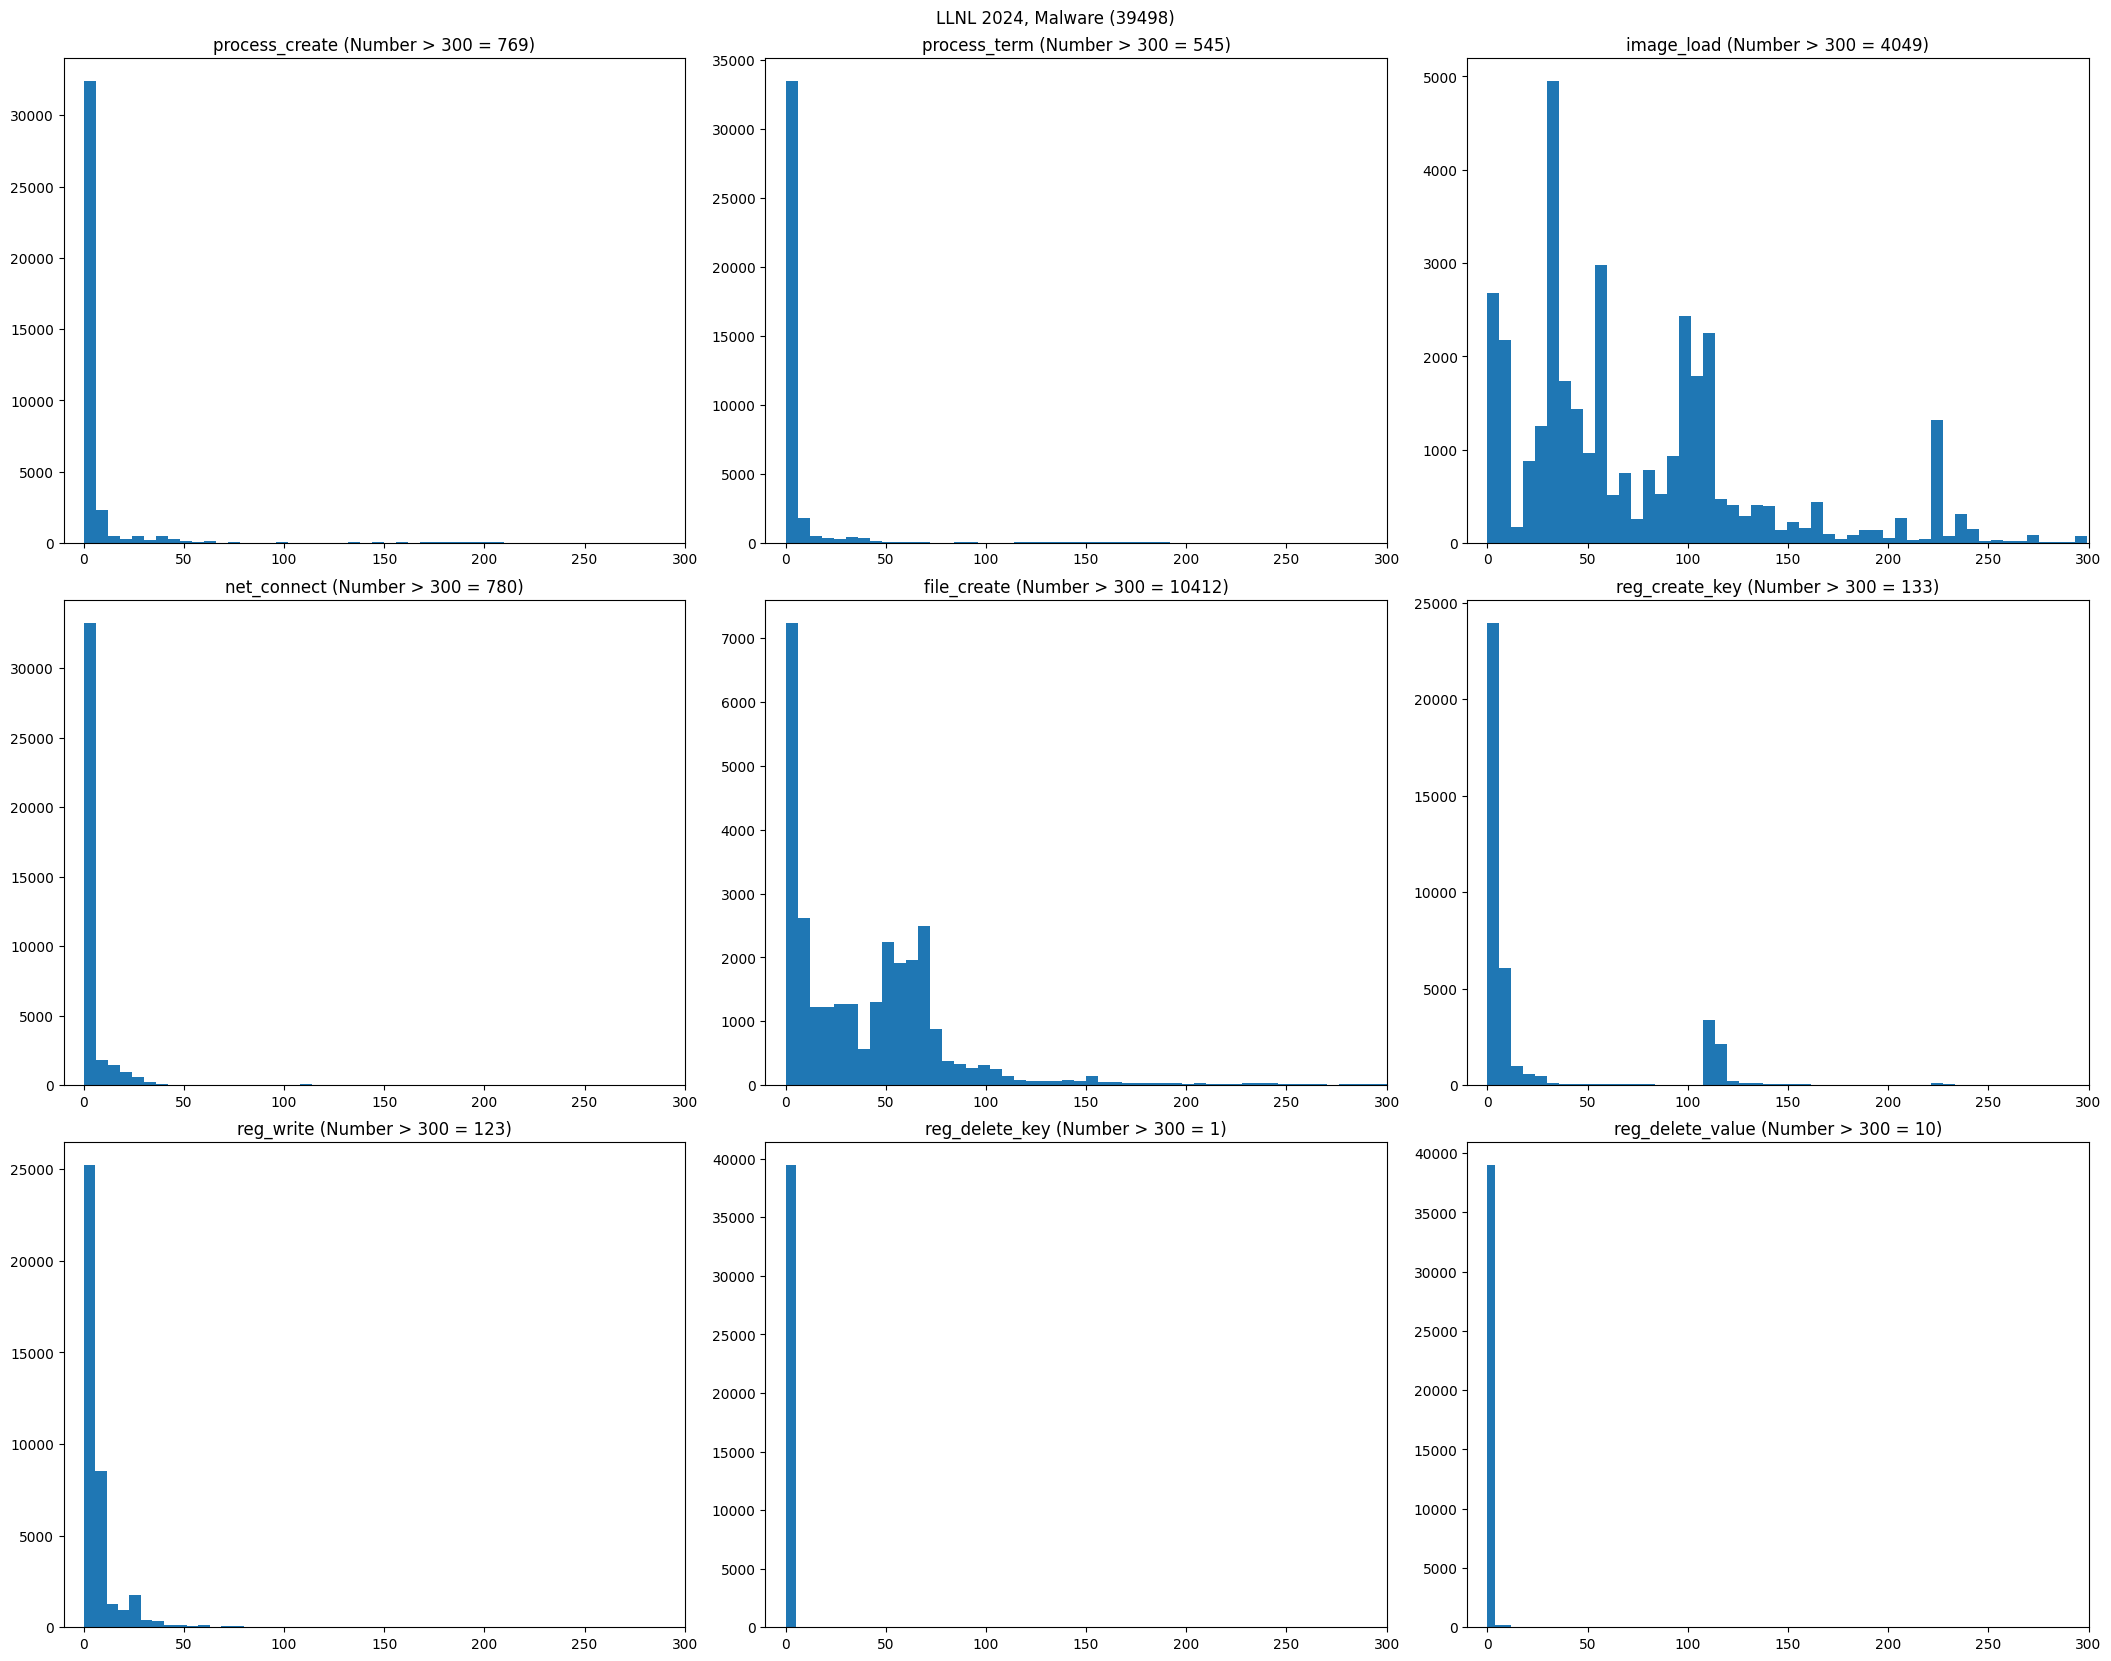

<Figure size 640x480 with 0 Axes>

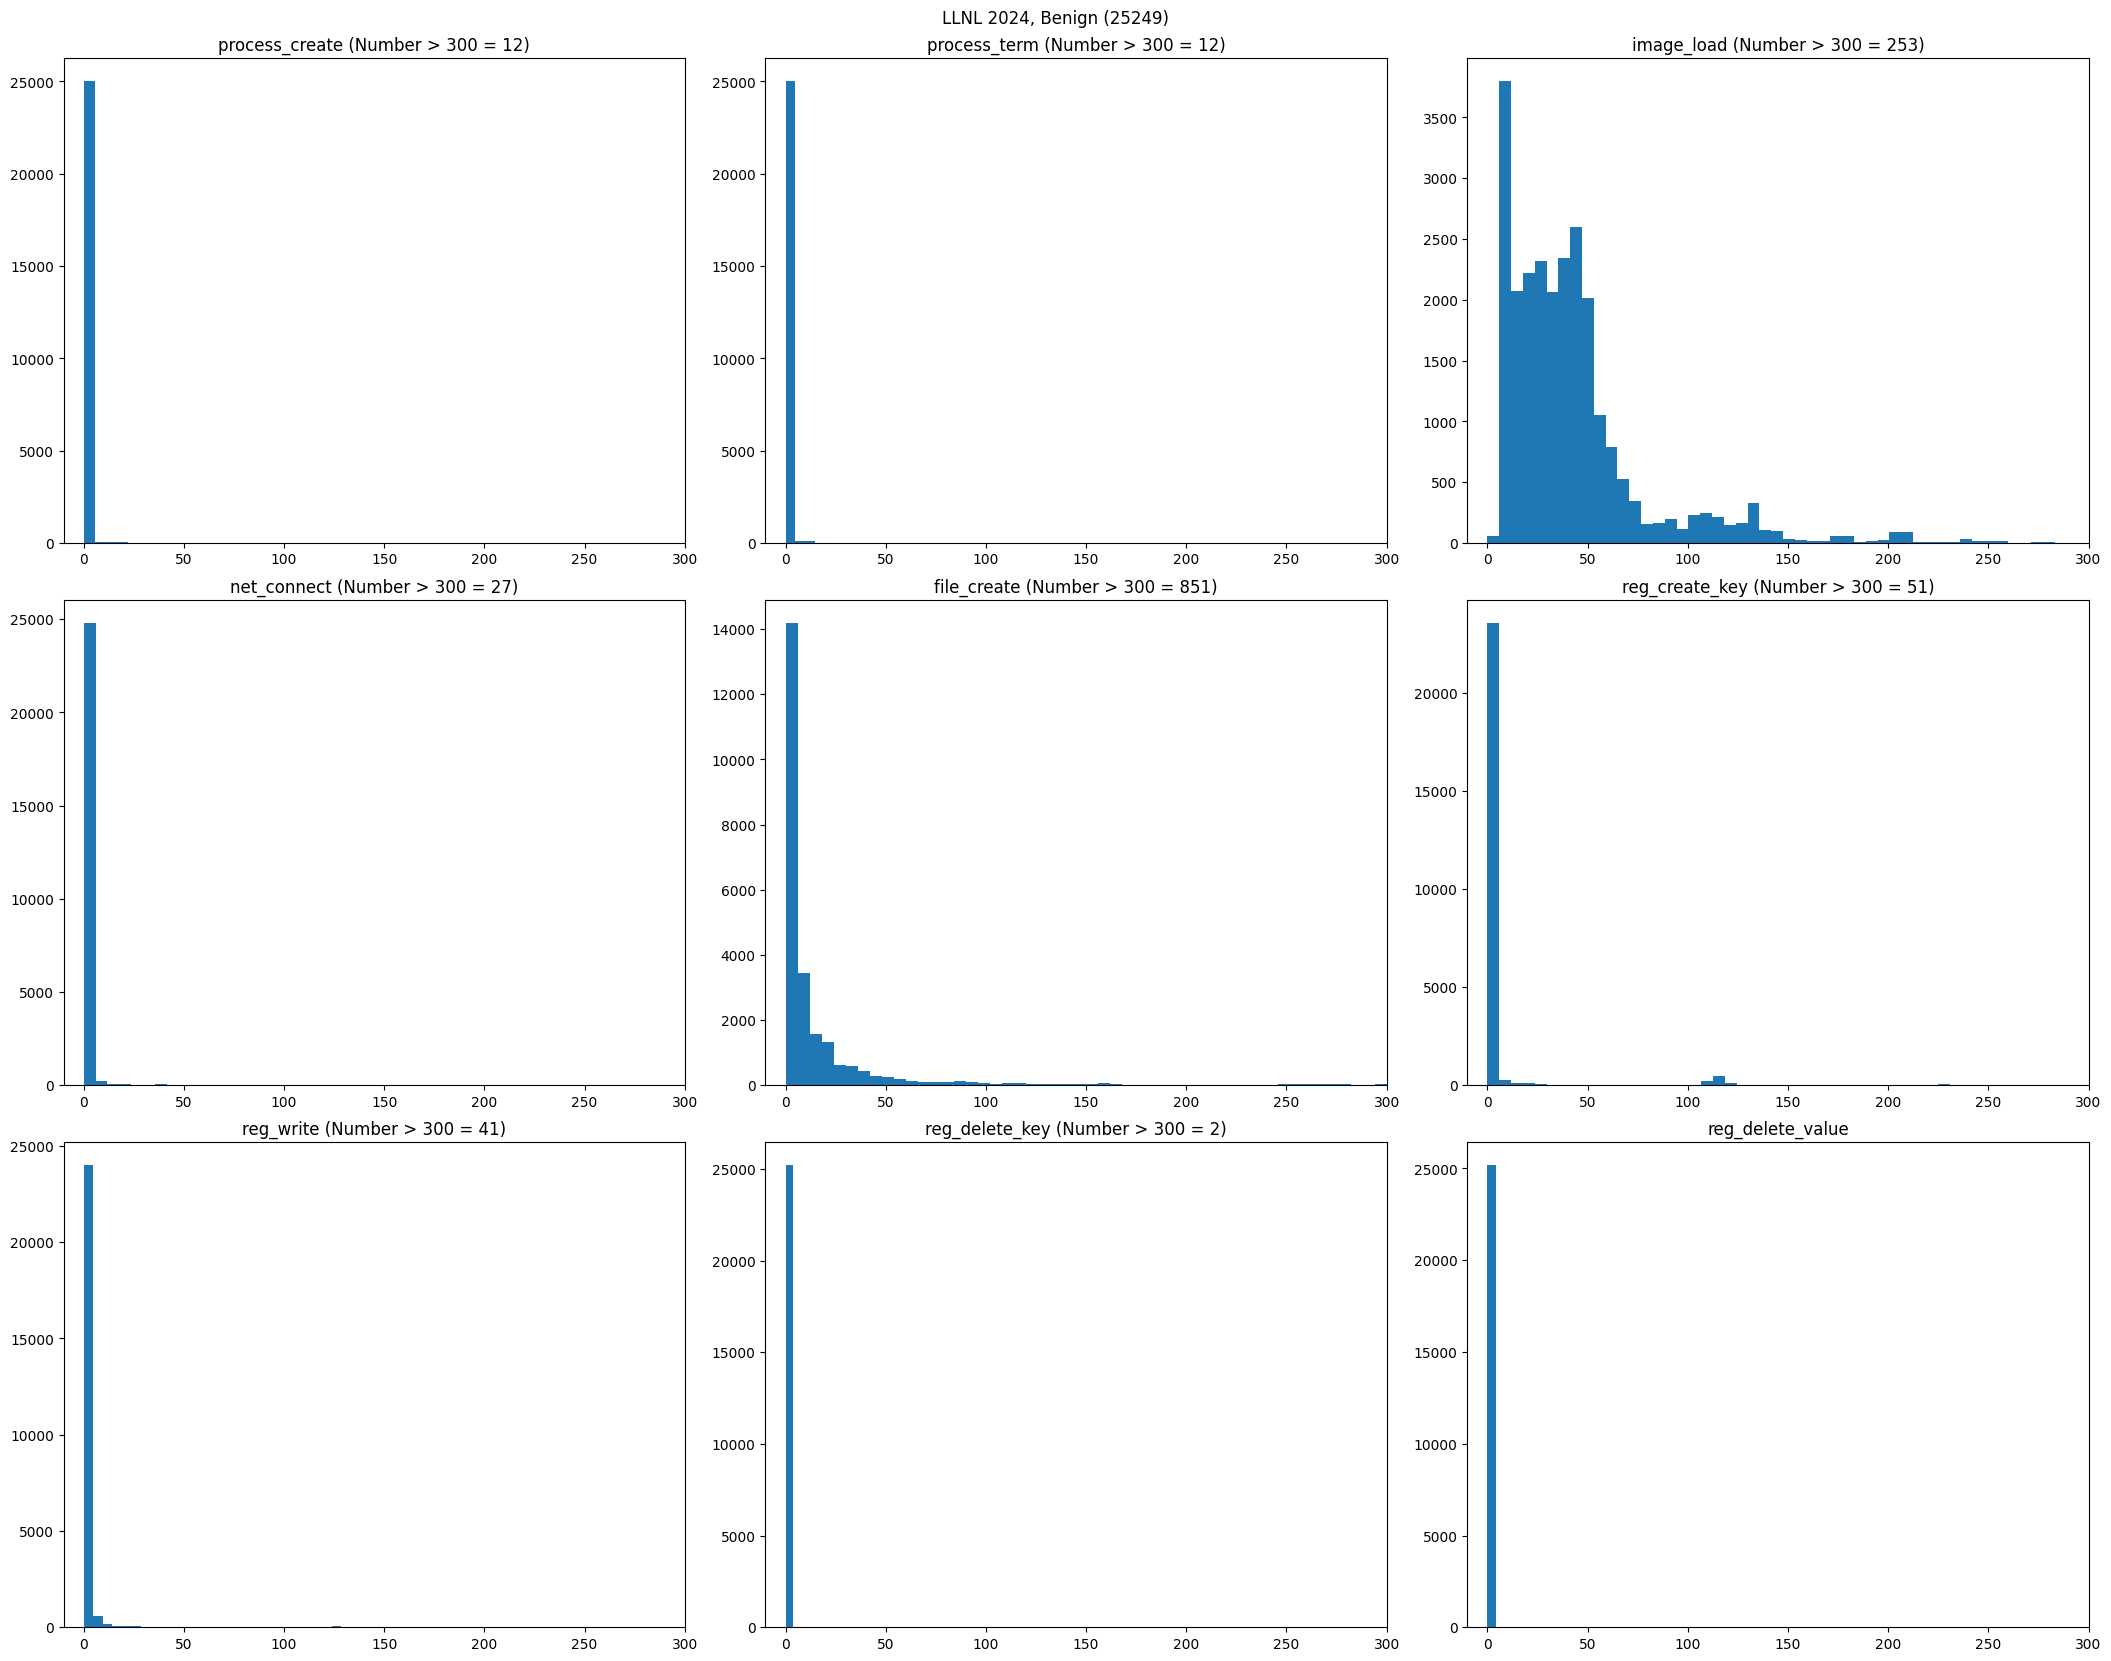

In [7]:
# Plot some histograms of counts
count_labels = ['process_create','process_term','image_load','net_connect','file_create','reg_create_key',
                'reg_write', 'reg_delete_key','reg_delete_value']
display_graphs(summary_mal,count_labels,3,'LLNL 2024, Malware',300)
display_graphs(summary_benign,count_labels,3,'LLNL 2024, Benign',300)

(40000, 13) (24747, 13)

10 Fold X-Validation Results 

Accuracy:  91.715 %
Malware Recall =  0.90435
Malware Precision =  0.9281096059113301
F1 Mal =  0.916075769854133
Benign Recall =  0.92995
Benign Precision =  0.9067375195007801
[[18599  1401]
 [ 1913 18087]]
Roc_AUC (max fpr  0.1 ) 0.9169246751644737

Test Results 

Accuracy:  92.5122237038833 %
Malware Recall =  0.9256333982972612
Malware Precision =  0.9781583654002494
F1 Mal =  0.9511713088618936
Benign Recall =  0.9232234711373595
Benign Precision =  0.7696950444726811
[[ 4846   403]
 [ 1450 18048]]
Roc_AUC (max fpr  0.1 ) 0.9314790402450928


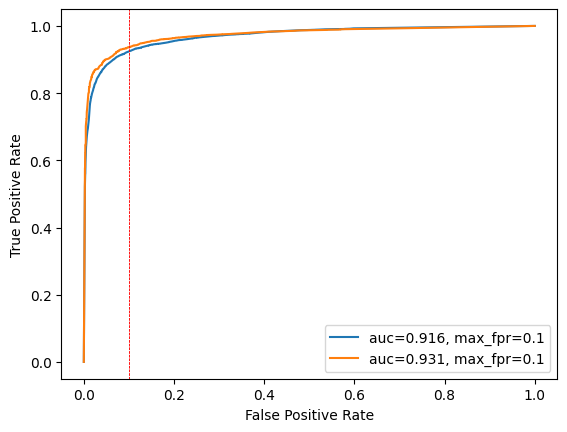

In [8]:
# Basic machine learning using counts
cross_val = True
max_fpr = 0.1
ml_labs = ['process_create', 'process_term','reg_create_key', 'reg_write', 'file_create', 'image_load',
           'reg_delete_key', 'net_connect', 'reg_delete_value']
df_train = summary_df_exp[summary_df_exp['test']==False]
df_test = summary_df_exp[summary_df_exp['test']]
print(df_train.shape, df_test.shape)
x_train = df_train[ml_labs]
x_test = df_test[ml_labs]
y_train = df_train['label'].values
y_test = df_test['label'].values
if cross_val:
    #
    # cross validation on training
    #
    clf = RandomForestClassifier(random_state=1, n_estimators=200)
    skf = StratifiedKFold(n_splits=10) 
    y_prob = cross_val_predict(clf, x_train, y_train, cv = skf, method = 'predict_proba', n_jobs=-1)
    y_train_prob = []
    y_train_predict = []
    threshold = 0.5
    for item in y_prob:
        prob = item[1]
        y_train_prob.append(prob)
        if prob >= threshold:
            pred = 'malicious'
        else:
            pred = 'benign'
        y_train_predict.append(pred)    
    
    recall_mal = recall_score(y_train, y_train_predict, labels=None, pos_label='malicious')
    precision_mal = precision_score(y_train, y_train_predict, labels=None, pos_label='malicious')
    recall_ben = recall_score(y_train, y_train_predict, labels=None, pos_label='benign')
    precision_ben = precision_score(y_train, y_train_predict, labels=None, pos_label='benign')
    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob,pos_label='malicious')
    roc_auc = roc_auc_score(y_train, y_train_prob,max_fpr=max_fpr)
    print('\n10 Fold X-Validation Results \n')
    print('Accuracy: ',100*sum(y_train==y_train_predict)/len(y_train),'%')
    print("Malware Recall = ",recall_mal)
    print("Malware Precision = ",precision_mal)
    print("F1 Mal = ",2*precision_mal*recall_mal/(precision_mal+recall_mal))
    print("Benign Recall = ",recall_ben)
    print("Benign Precision = ",precision_ben)
    print(confusion_matrix(y_train,y_train_predict))
    print('Roc_AUC (max fpr ',max_fpr,')',roc_auc)
    plt.plot(fpr, tpr,label="auc="+str(roc_auc)[:5] + ', max_fpr=' + str(max_fpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.axvline(x=max_fpr, color='r', linestyle='--', linewidth=0.5)
    plt.legend(loc=4)

# Test Results
clf = RandomForestClassifier(random_state=1, n_estimators=200).fit(x_train, y_train)

y_test_predict = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)
y_test_prob = []
for item in y_prob:
    y_test_prob.append(item[1])

recall_mal = recall_score(y_test, y_test_predict, labels=None, pos_label='malicious')
precision_mal = precision_score(y_test, y_test_predict, labels=None, pos_label='malicious')
recall_ben = recall_score(y_test, y_test_predict, labels=None, pos_label='benign')
precision_ben = precision_score(y_test, y_test_predict, labels=None, pos_label='benign')
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob,pos_label='malicious')
roc_auc = roc_auc_score(y_test, y_test_prob, max_fpr=max_fpr)
title = '\nTest Results'
print(title,'\n')
print('Accuracy: ',100*sum(y_test==y_test_predict)/len(y_test),'%')
print("Malware Recall = ",recall_mal)
print("Malware Precision = ",precision_mal)
print("F1 Mal = ",2*precision_mal*recall_mal/(precision_mal+recall_mal))
print("Benign Recall = ",recall_ben)
print("Benign Precision = ",precision_ben)
print(confusion_matrix(y_test,y_test_predict))
print('Roc_AUC (max fpr ',max_fpr,')',roc_auc)
plt.plot(fpr, tpr,label="auc="+str(roc_auc)[:5] + ', max_fpr=' + str(max_fpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axvline(x=max_fpr, color='r', linestyle='--', linewidth=0.5)
plt.legend(loc=4)

Top 20 Features
image_load
file_create
reg_create_key
net_connect
reg_write
process_create
process_term
reg_delete_value
reg_delete_key


Text(0.5, 1.0, 'Top Features')

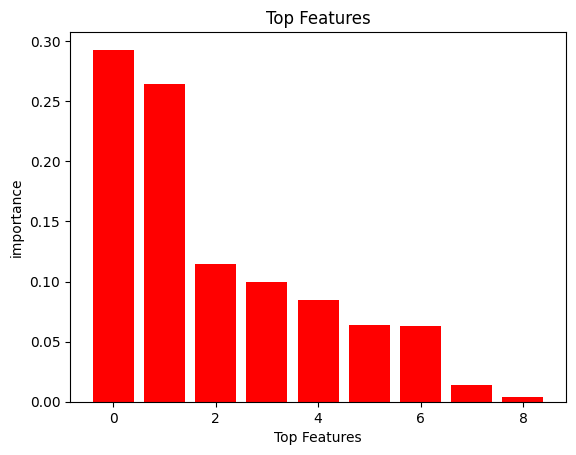

In [9]:
# 
# Feature Importance
#
num_imp = min(500, len(ml_labs))
#fit=clf.fit(x_scale[:, 0:num_imp],y)
#fit=clf.fit(x_scale,y)
print('Top 20 Features')
for topfeature in np.array(ml_labs)[np.flip(np.argsort(clf.feature_importances_))][:20]:
    print(topfeature)
    
plt.bar(range(num_imp), sorted(clf.feature_importances_,reverse=True)[:num_imp], color="r",  align="center")
plt.ylabel('importance')
plt.xlabel('Top Features')
plt.title('Top Features')